# **Imports**

In [ ]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    %tensorflow_version 1.x

import os, sys
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

from tqdm import tqdm_notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt

# **Mount**

In [ ]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
from pathlib import Path

folder = "Colab Notebooks"
project_dir = "NeRF"

base_path = Path("/content/gdrive/My Drive/")
project_path = base_path / folder / project_dir
os.chdir(project_path)
for x in list(project_path.glob("*")):
    if x.is_dir():
        dir_name = str(x.relative_to(project_path))
        os.rename(dir_name, dir_name.split(" ", 1)[0])
print(f"현재 디렉토리 위치: {os.getcwd()}")

현재 디렉토리 위치: /content/gdrive/My Drive/Colab Notebooks/NeRF


# **Download Dataset**

In [ ]:
if not os.path.exists('tiny_nerf_data.npz'):
    !wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz

# **Load Input Images and Poses**

(106, 100, 100, 3)
(106, 4, 4)
138.88887889922103


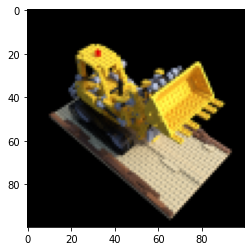

In [ ]:
data = np.load('tiny_nerf_data.npz')
images = data['images']
print(images.shape) # 106개의 사진, 100*100, RGB
poses = data['poses']
print(poses.shape) # 106개의 사진, ??
focal = data['focal']
print(focal) # ??
H, W = images.shape[1:3] # 100*100

testimg = images[101] # 102번째 사진으로 test
images = images[:100,...,:3] # 100개의 사진 선정, 100*100, RGB
poses = poses[:100] # 100개의 사진 선정

plt.imshow(testimg)
plt.show()

# **Optimize NeRF**

In [ ]:
# positional encoding
# tf.Tensor를 input으로 하고, 2^i *pi * input만큼 sin, cos해서 ret에 추가
# shape: (data, 3) => (data, 3 * (2 * L_embed + 1))

def posenc(x):
  rets = [x]
  for i in range(L_embed):
    for fn in [tf.sin, tf.cos]:
      rets.append(fn(2.**i * x))
  return tf.concat(rets, -1)

#parameters
L_embed = 6
embed_fn = posenc

# parameters_no positional encoding
# L_embed = 0
# embed_fn = tf.identity

In [ ]:
# 모델 정의(논문에서의 설명보다는 간소화된 상태)
# MLP로 구성, xyz -> RGBa 변환
# D = depth(몇 층으로 구성되어 있는가), W = weight(중간 층에서의 dimension)

def init_model(D=8, W=256):
    relu = tf.keras.layers.ReLU()
    dense = lambda W=W, act=relu : tf.keras.layers.Dense(W, activation=act)

    inputs = tf.keras.Input(shape=(3 + 3 * 2 * L_embed))  # 3(xyz)) + positional encoding
    outputs = inputs
    for i in range(D):
        outputs = dense()(outputs)
        if i%4==0 and i>0:
            outputs = tf.concat([outputs, inputs], -1) #네트워크 중간에 input을 다시 넣어줌
    outputs = dense(4, act=None)(outputs) #최종 output은 4차원
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
# 특정 각도에서, 각 픽셀에 대한 광선 구하기(r(t) = o + td)
# 함수 내용은 모르겠습니다.. 각 픽셀마다의 r(t) 계산 위한 o, d를 output으로 함
# output shape: 100*100(픽셀) * 2(o, d) * 3(xyz)

def get_rays(H, W, focal, c2w):
    i, j = tf.meshgrid(tf.range(W, dtype=tf.float32), tf.range(H, dtype=tf.float32), indexing='xy')
    dirs = tf.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -tf.ones_like(i)], -1)
    rays_d = tf.reduce_sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)
    rays_o = tf.broadcast_to(c2w[:3,-1], tf.shape(rays_d))
    return rays_o, rays_d

In [ ]:
# 렌더링
def render_rays(network_fn, rays_o, rays_d, near, far, N_samples, rand=False):

    # batch normalization??
    def batchify(fn, chunk=1024*32):
        return lambda inputs : tf.concat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0)
    
    # 각 t(z_vals)에 대한 r(t) 구하기 => uniform sampling
    z_vals = tf.linspace(near, far, N_samples) 
    if rand:
      z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None]
    
    # MLP를 통해 각 샘플에 대한 RGBa 구하기
    # (100, 100, 64, 3)
    pts_flat = tf.reshape(pts, [-1,3]) #100 * 100 * 64(sample) -> 640000
    # (640000, 3)
    pts_flat = embed_fn(pts_flat) # positional encoding 적용
    # (640000, 39)
    raw = batchify(network_fn)(pts_flat) # model 적용(xyz * (2 * L_embed + 1) -> RGBa)
    # (640000, 4)
    raw = tf.reshape(raw, list(pts.shape[:-1]) + [4]) #640000 -> 100 * 100 * 64(sample)
    # (100, 100, 64, 4)

    # RGB(색상)와 a(밀도) 분리
    rgb = tf.math.sigmoid(raw[...,:3]) 
    sigma_a = tf.nn.relu(raw[...,3])

    # 볼륨 렌더링
    dists = tf.concat([z_vals[..., 1:] - z_vals[..., :-1], tf.broadcast_to([1e10], z_vals[...,:1].shape)], -1) 
    alpha = 1.-tf.exp(-sigma_a * dists)  
    weights = alpha * tf.math.cumprod(1.-alpha + 1e-10, -1, exclusive=True)
    
    rgb_map = tf.reduce_sum(weights[...,None] * rgb, -2) 
    depth_map = tf.reduce_sum(weights * z_vals, -1) 
    acc_map = tf.reduce_sum(weights, -1)

    return rgb_map, depth_map, acc_map

In [ ]:
import time
t = time.time()

N_samples = 64
N_iters = 1000
i_plot = 25
psnrs = []
iternums = []

model = init_model()
optimizer = tf.keras.optimizers.Adam(5e-4)

In [ ]:
for i in range(N_iters+1):
    # 랜덤으로 하나의 학습에 사용할 이미지 가져오기
    img_rand = np.random.randint(images.shape[0])
    target = images[img_rand]
    pose = poses[img_rand]
    
    # 학습
    with tf.GradientTape() as tape:
        # 선택한 각도에서, 각 픽셀에 대한 광선 구하기(r(t) = o + td)
        rays_o, rays_d = get_rays(H, W, focal, pose)
        # 선택한 이미지에서의 각도에 대한 렌더링(hierarchical sampling은 구현하지 않음)
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples, rand=True)
        # 렌더링된 이미지와 실제 이미지와의 오차 계산
        loss = tf.reduce_mean(tf.square(rgb - target))
        # 계산한 오차를 가지고 학습
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    # 학습 횟수가 25의 배수면 logging
    if i%i_plot==0:

        # 학습당 평균 시간 측정
        print('Epoch:', '%d'%i, ', secs per iter:', '%0.9f'%((time.time() - t) / i_plot))
        t = time.time()
        
        # 현재까지의 학습 결과를 가지고 렌더링
        rays_o, rays_d = get_rays(H, W, focal, testpose)
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
        loss = tf.reduce_mean(tf.square(rgb - testimg))

        #그래프 출력
        plt.figure(figsize=(10,4)) #가로 10인치, 세로 4인치

        #그래프 출력 - 현재까지 학습 결과로 렌더링한 이미지
        plt.subplot(121) #rows = 1, cols = 2의 index = 1
        plt.imshow(rgb)
        plt.title(f'Iteration: {i}')
  
        #그래프 출력 - epoch당 PSNR(평가 지표, 높을수록 좋음)
        plt.subplot(122) #rows = 1, cols = 2의 index = 2
        iternums.append(i)
        psnr = -10. * tf.math.log(loss) / tf.math.log(10.)
        psnrs.append(psnr.numpy())
        plt.plot(iternums, psnrs)
        plt.title('PSNR')

        plt.show()

print('Done')

Output hidden; open in https://colab.research.google.com to view.

# **Interactive Visualization**

In [ ]:
%matplotlib inline
from ipywidgets import interactive, widgets


trans_t = lambda t : tf.convert_to_tensor([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1],
], dtype=tf.float32)

rot_phi = lambda phi : tf.convert_to_tensor([
    [1,0,0,0],
    [0,tf.cos(phi),-tf.sin(phi),0],
    [0,tf.sin(phi), tf.cos(phi),0],
    [0,0,0,1],
], dtype=tf.float32)

rot_theta = lambda th : tf.convert_to_tensor([
    [tf.cos(th),0,-tf.sin(th),0],
    [0,1,0,0],
    [tf.sin(th),0, tf.cos(th),0],
    [0,0,0,1],
], dtype=tf.float32)


def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w = np.array([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]) @ c2w
    return c2w


def f(**kwargs):
    c2w = pose_spherical(**kwargs)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4])
    rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
    img = np.clip(rgb,0,1)
    
    plt.figure(2, figsize=(20,6))
    plt.imshow(img)
    plt.show()
    

sldr = lambda v, mi, ma: widgets.FloatSlider(
    value=v,
    min=mi,
    max=ma,
    step=.01,
)

names = [
    ['theta', [100., 0., 360]],
    ['phi', [-30., -90, 0]],
    ['radius', [4., 3., 5.]],
]

interactive_plot = interactive(f, **{s[0] : sldr(*s[1]) for s in names})
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=100.0, description='theta', max=360.0, step=0.01), FloatSlider(value=-…

# **Render 360 Video**

In [ ]:
frames = []
for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):
    c2w = pose_spherical(th, -30., 4.)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4])
    rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
    frames.append((255*np.clip(rgb,0,1)).astype(np.uint8))

import imageio
f = 'video.mp4'
imageio.mimwrite(f, frames, fps=30, quality=7)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/120 [00:00<?, ?it/s]

In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)